 **DATA WRANGLING**

**This capstone project addresses using proteomic data (protein and peptide data) from patients with Parkinson’s disease to predict the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) score for patients for that visit and any potential future visits 6, 12 and 24 months later.**
The data has been downloaded from a kaggle competition using the following url:
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/data.
The data sources are the following:
Training_dataset
train_peptides.csv-Mass spectrometry data at the peptide level
train_proteins.csv-Protein expression frequencies
Train_clinical_data.csv- Clinical information including patient ID, visit status, UPDRS score
Test dataset- Delivered through API
example_test_files-Data intended to illustrate how the API functions. .
Amp_pd_peptide- Files that enable the API. 
public_timeseries_testing_util.py An optional file intended to make it easier to run custom offline API tests. 



Import required libraries to enable the task



In [38]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


Load the proteomic data files from the Parkinson's training dataset

In [39]:
Training_protein=pd.read_csv('training_data/train_proteins.csv')
Training_protein.head()



,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [3]:
Training_protein.shape

(232741, 5)

You can see that each protein concentration is an NPX value, and the protein ID is UniProt.  

Given the shape of the dataframe we donot know how many patients and UniProt values there are. We will use unique function to find that out.

In [4]:
Training_protein.patient_id.nunique()

248

In [5]:
Training_protein.UniProt.nunique()

227

There are 248 patients and 227 proteins in the dataset.

In [6]:
Training_protein.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


The info function tells us that there are no missing values for the training protein data.There are 232741 rows and 5 columns

In [7]:
Training_protein.describe()

,visit_month,patient_id,NPX
count,232741.000000,232741.000000,2.327410e+05
mean,26.099205,32593.881873,2.712077e+06
std,22.874719,18608.479506,2.224155e+07
min,0.000000,55.000000,8.460820e+01
25%,6.000000,16566.000000,2.946440e+04
50%,24.000000,29313.000000,1.135560e+05
75%,48.000000,49995.000000,5.638940e+05
max,108.000000,65043.000000,6.138510e+08


The visit_month values do not make sense, let us plot them as a hist distribution

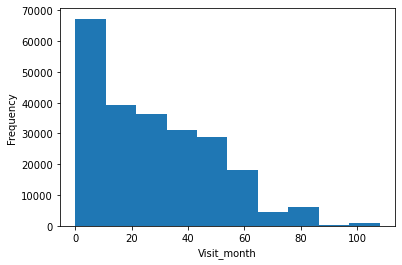

In [40]:
_=Training_protein["visit_month"].plot(kind="hist",bins=10)
_=plt.xlabel("Visit_month")
plt.show()

You can look at the values of the visit_month and see that they are whole range of values, we have to predict the UPDRS values for the patients at time point months, 6, 12 and 24 months later.
Let us see for how many patient_IDs have 0, 6, 12 and 24 month values.

In [41]:
Training_protein.groupby("visit_month").size()






visit_month
0      40587
3        641
6      25991
12     37467
18      1657
24     36225
30       216
36     31156
48     28838
54       418
60     17572
72      4407
84      6288
96       423
108      855
dtype: int64

When we look at the frequency of the visit_month, we can see that the number of patients with protein data reduces fron 0, 6,12 and 24 months.

Next we will look at the distribution of the NPX values

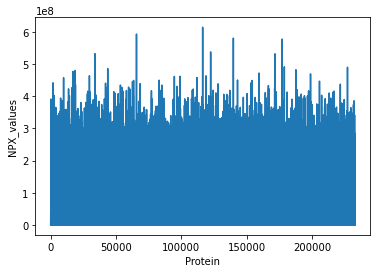

In [42]:
_=plt.plot(Training_protein['NPX'].values)
_=plt.xlabel("Protein")
_=plt.ylabel("NPX_values")
plt.show()

Given the distribution of the values, to make any comparisons we will be log2 normalising the data.

In [43]:
Training_protein.groupby("UniProt").size().sort_values()

UniProt
Q99829     489
Q99832     606
Q562R1     616
P01780     654
Q6UX71     661
          ... 
P02774    1113
P02787    1113
P02790    1113
Q12805    1113
P01042    1113
Length: 227, dtype: int64

Let us look at the training_peptide dataset now.

In [44]:
Training_peptide=pd.read_csv('training_data/train_peptides.csv')
Training_peptide.head()



,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


The training_peptide dataset has information on peptide and peptide abundance, the rest of the columns are the same as the protein column.

In [45]:
Training_peptide.patient_id.nunique()

248

In [46]:
Training_peptide.Peptide.nunique()

968

There are 968 unique peptides for the 248 patients

In [47]:
Training_peptide.describe()

,visit_month,patient_id,PeptideAbundance
count,981834.000000,981834.000000,9.818340e+05
mean,26.105061,32603.465361,6.428902e+05
std,22.913897,18605.934422,3.377989e+06
min,0.000000,55.000000,1.099850e+01
25%,6.000000,16566.000000,2.817425e+04
50%,24.000000,29313.000000,7.430830e+04
75%,48.000000,49995.000000,2.213388e+05
max,108.000000,65043.000000,1.787520e+08


In [48]:
Training_peptide.groupby("visit_month").size()

visit_month
0      171048
3        2742
6      110733
12     158114
18       6822
24     152036
30        913
36     130903
48     121343
54       1801
60      74562
72      18642
84      26729
96       1815
108      3631
dtype: int64

We can see that peptide data varys for different months.

In [49]:
Training_peptide.groupby("UniProt").size().sort_values()

UniProt
Q99829      489
Q99832      606
Q562R1      616
P01780      654
Q6UX71      661
          ...  
P02649    23082
P02751    27370
P01024    35253
P02768    40900
P02787    51916
Length: 227, dtype: int64

The no of peptides per protein also varys in the dataset

In [50]:
Training_peptide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [51]:
Training_peptide.dtypes

visit_id             object
visit_month           int64
patient_id            int64
UniProt              object
Peptide              object
PeptideAbundance    float64
dtype: object

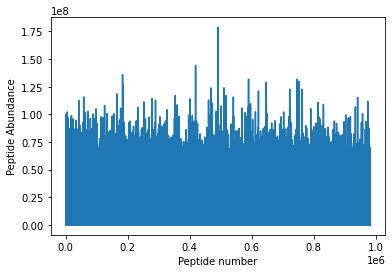

In [52]:
###Check how the peptide abundances look like
_=plt.plot(Training_peptide['PeptideAbundance'].values)
_=plt.xlabel("Peptide number")
_=plt.ylabel("Peptide Abundance")
plt.show()

Let us look at whether there are missing values in the protein and peptide datasets

In [53]:
Training_protein.isnull().sum()


visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

There are no missing values for protein in the training dataset.

In [54]:
Training_peptide.isnull().sum()


visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

No missing values for the peptide in training dataset.

Now we will be combining training_protein and training_peptide data for future use

In [55]:
Training_protein_peptide=  Training_peptide.merge(Training_protein,  on=['visit_id','visit_month','patient_id','UniProt'])



After doing a merge of the peptide and protein training datasets, let us look at how the dataset looks like

In [56]:
Training_protein_peptide.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0


We will now look at the clinical data for the training dataset.

In [57]:
Training_clinical=pd.read_csv('training_data/train_clinical_data.csv')
Training_clinical.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


Let us have a look at the whether there are any missing values and what percentage of missing values there are for each attribute.

In [58]:
Training_clinical.isnull().sum()
missing = pd.concat([Training_clinical.isnull().sum(), 100 * Training_clinical.isnull().mean()], axis=1)

missing.columns=["count", "%"]
missing.sort_values(by=["count", "%"])

,count,%
visit_id,0,0.000000
patient_id,0,0.000000
visit_month,0,0.000000
updrs_1,1,0.038241
updrs_2,2,0.076482
updrs_3,25,0.956023
updrs_4,1038,39.694073
upd23b_clinical_state_on_medication,1327,50.745698


We know that there are missing values for our training clinical dataset. Very high percentage of missing values for updrs_4 and upd23b_clinical_state_on_medication. The upd23b_clinical_state_on_medication is Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function; UPDRS_3). Given that it is not a target variable I will remove it. UPDRS scores are important for prediction so we will impute the missing values .

What are the range of values for UPDRS_4 scores


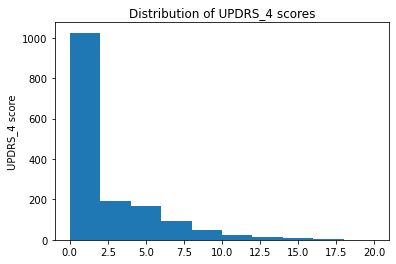

In [59]:
_=plt.hist(Training_clinical.updrs_4)
_=plt.ylabel("UPDRS_4 score")
_=plt.title("Distribution of UPDRS_4 scores")
plt.show()

Since the most common value (mode) for UPDRS_4 score is 0, we will impute missing values of UPDRS_4 with it.The median is also 0 for this dataset.

In [60]:
Training_clinical["updrs_4"] = Training_clinical["updrs_4"].fillna(0)

For the rest of the scores we will will also impute missing values with median which is most robust to outliers

In [61]:
Training_clinical["updrs_1"] = Training_clinical["updrs_1"].fillna(Training_clinical['updrs_1'].median())
Training_clinical["updrs_2"] = Training_clinical["updrs_2"].fillna(Training_clinical['updrs_2'].median())
Training_clinical["updrs_3"] = Training_clinical["updrs_3"].fillna(Training_clinical['updrs_3'].median())

In [62]:

Training_clinical.drop(columns=["upd23b_clinical_state_on_medication"], inplace=True)

In [63]:
Training_clinical.isnull().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
dtype: int64

Let us look at the range of visit_months in the training clinical dataset

In [64]:

Training_clinical.groupby("visit_month").size()

visit_month
0      248
3      115
6      192
9       99
12     243
18     187
24     243
30     173
36     226
42     154
48     196
54     110
60     166
72      93
84     100
96      58
108     12
dtype: int64

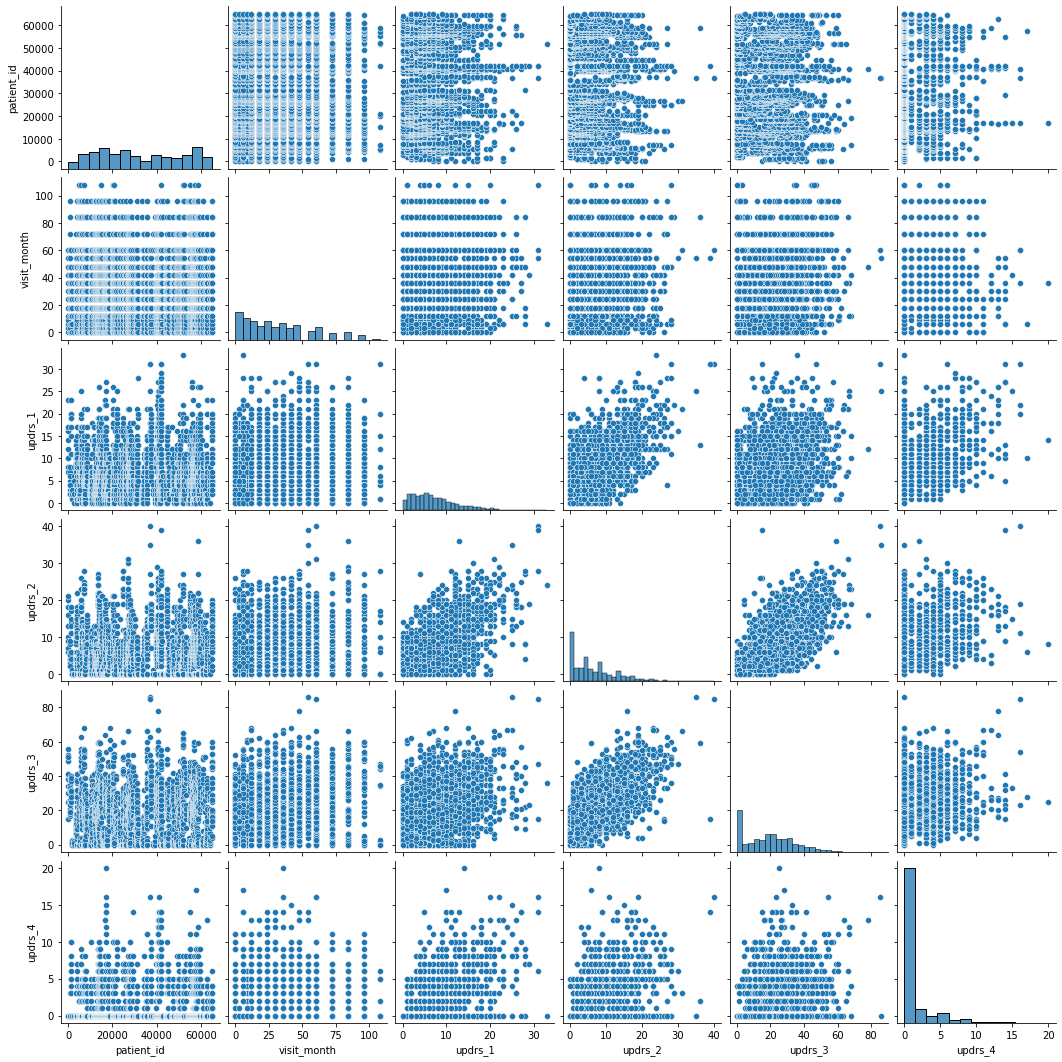

In [65]:
###Explore the relationship between the different UPDRS scores, are they correlated in anyway

_=sns.pairplot(Training_clinical, kind="scatter")
plt.show()


There is a correlation between the UPDRS scores. Let us look at the strength of the correlations.

In [33]:
#There seems to be a correlation between the UPDRS scores, let us look at correlations
Training_clinical.columns
Training_clinical[["updrs_1","updrs_2","updrs_3","updrs_4"]].corr()

,updrs_1,updrs_2,updrs_3,updrs_4
updrs_1,1.000000,0.661725,0.432324,0.440844
updrs_2,0.661725,1.000000,0.732674,0.414635
updrs_3,0.432324,0.732674,1.000000,0.298535
updrs_4,0.440844,0.414635,0.298535,1.000000


Higher correlation between the updrs_2 with updrs_1 and updrs_3 compared to with  updrs_4

Let us look if the testing_datasets are in a similar format to the training_datasets

In [34]:
###Let us look if the testing_datasets are in a similar format to the training_datasets
Testing_protein=pd.read_csv('testing_data/example_test_files/test_proteins.csv')
Testing_protein.head()


,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [35]:
Testing_peptide=pd.read_csv('testing_data/example_test_files/test_peptides.csv')
Testing_peptide.head()


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [36]:
Testing_clinical=pd.read_csv('testing_data/example_test_files/test.csv')
Training_clinical.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_3,55,3,10.0,7.0,25.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0


Yes the training and test datasets have similar formats. We will not combine the test protein and peptide datasets for now.

We will save cleaned files to be used for the EDA

In [66]:
Training_clinical.to_csv('Training_clinical_cleaned.csv',index=False)
Training_protein_peptide.to_csv("Protein_peptide_training.csv",index=False)


